In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold

import scipy.stats as stats

from tqdm.notebook import trange, tqdm

from utils import get_label, get_multi_label, plot_roc, evaluate, Imputer, Vectorizer, Splitter
from models import WeightedLogisticRegression

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [7]:
def label_from_multi(y_multi):
    return torch.tensor([1 if y == 0 else 0 for y in y_multi]).float()

data = pd.read_csv("data/train.tsv", sep="\t")
x_all, y_all_multi = data.drop("label", axis=1), get_multi_label(data)
x_train, x_test, y_train_multi, y_test_multi = train_test_split(data.drop("label", axis=1), get_multi_label(data), random_state=RANDOM_SEED)
y_train = label_from_multi(y_train_multi)
y_test = label_from_multi(y_test_multi)
y_all = label_from_multi(y_all_multi)

In [92]:
impute_vectorize = Pipeline([
    ("imputer", Imputer), ("vectorizer", Vectorizer)
])

split_vectorize = Pipeline([
    ("splitter", Splitter), ("vectorizer", Vectorizer)
])

column_transformer = ColumnTransformer([
       ("statement_vectorizer", Vectorizer ,"statement"),
        ("subject_vectorizer", split_vectorize, "subject"),
        ("job", impute_vectorize, "speaker_job"),
        ("state", impute_vectorize, "state"),
        ("party", impute_vectorize, "party"),
        ("context", impute_vectorize, "context")
    ])


r = 1.85
loss_weights = (1/r, 1, r, r**2, r**3)


pipe_weighted = Pipeline([
    ("get_features", column_transformer),
    ("predict", WeightedLogisticRegression(loss_weights=loss_weights, lr=0.1, l1=0.0, l2=0.0002, max_iter=1000, tol=1e-6, plot_loss=False, verbose=False))
])


pipe_standard = Pipeline([
    ("get_features", column_transformer),
    ("predict", LogisticRegression(max_iter=1000, tol=1e-6, C=0.64))
])

In [93]:
kf = KFold(n_splits=100)
kf.get_n_splits(x_all);

In [94]:
roc_aucs_weighted = []
roc_aucs_standard = []

In [95]:
for train_index, test_index in tqdm(kf.split(x_all)):
    x_train, x_test = x_all.iloc[train_index], x_all.iloc[test_index]
    y_train_multi, y_test_multi = y_all_multi[train_index], y_all_multi[test_index]
    y_train = label_from_multi(y_train_multi)
    y_test = label_from_multi(y_test_multi)
    
    pipe_weighted.fit(x_train, y_train_multi)
    roc_aucs_weighted.append(evaluate(pipe_weighted, x_test, y_test, verbose=False))
    
    pipe_standard.fit(x_train, y_train)
    roc_aucs_standard.append(evaluate(pipe_standard, x_test, y_test, verbose=False))

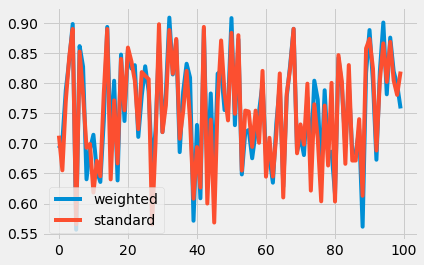

In [96]:
plt.plot(roc_aucs_weighted, label="weighted")
plt.plot(roc_aucs_standard, label="standard")
plt.legend();

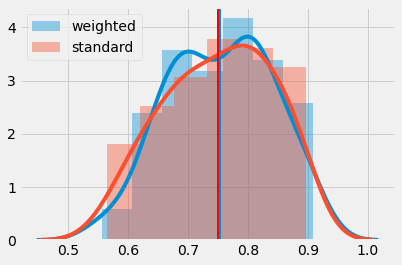

In [129]:
sns.distplot(roc_aucs_weighted, label="weighted")
plt.axvline(np.mean(roc_aucs_weighted), linewidth=2)
sns.distplot(roc_aucs_standard, label="standard")
plt.axvline(np.mean(roc_aucs_standard), color="red", linewidth=2)
plt.legend()

Differences are not statistically significant.

In [106]:
stats.wilcoxon(roc_aucs_weighted, roc_aucs_standard, alternative="greater")

WilcoxonResult(statistic=2655.5, pvalue=0.26434770301013255)

In [108]:
stats.ttest_ind(roc_aucs_weighted, roc_aucs_standard)

Ttest_indResult(statistic=0.24040246342614244, pvalue=0.8102669923075811)

In [109]:
np.mean(roc_aucs_weighted), np.mean(roc_aucs_standard)

(0.7539337261621927, 0.7509497543343393)

In [110]:
np.std(roc_aucs_weighted), np.std(roc_aucs_standard)

(0.08572364428314158, 0.08890534003176304)

In [114]:
f = np.var(roc_aucs_weighted) / np.var(roc_aucs_standard)
f

0.9297058342568306

In [115]:
stats.f.cdf(f, 100, 100)

0.3581212353962935

In [116]:
stats.levene(roc_aucs_weighted, roc_aucs_standard, center="median")

LeveneResult(statistic=0.0656390258845123, pvalue=0.7980615143869798)